# Clustering via Affinity Propagation

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

file_path_ISOMap_raw = "../../reduced_data/joueurs_ligue1_ISOMap_raw.csv"
file_path_ISOMap_per90 = "../../reduced_data/joueurs_ligue1_ISOMap_per90.csv"

data_ISOMap_raw = pd.read_csv(file_path_ISOMap_raw, encoding="utf-8")
data_ISOMap_per90 = pd.read_csv(file_path_ISOMap_per90, encoding="utf-8")
print(data_ISOMap_raw.head(1))

    isomap_1  isomap_2  isomap_3  isomap_4  isomap_5  isomap_6  isomap_7  \
0  21.062129 -4.222008 -2.173427 -3.796018 -2.686983  4.300071   2.18389   

     player_name  equipe positions  
0  Jordan Lefort  Angers        DF  


## Data Preparation : standardisation + columns removal

In [10]:
X_iso_raw = data_ISOMap_raw.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_iso_per90 = data_ISOMap_per90.drop(columns=['player_name', 'equipe', 'positions']).copy()

scaler = StandardScaler()
X_iso_raw = scaler.fit_transform(X_iso_raw) 
X_iso_per90 = scaler.fit_transform(X_iso_per90)
print(X_iso_raw[1])

[ 1.34474033  1.30283802 -2.32940855  1.67514762  2.58475243  0.03916205
  0.59423857]


## GridSearch Analysis

In [11]:
def affinity_gridsearch(X, damping_values=np.linspace(0.5, 0.95, 10), preference_values=np.linspace(-200, -20, 10) , random_state = 42):
    
    results = []

    if preference_values is None:
        median = np.median(-np.linalg.norm(X[:, None] - X[None, :], axis=2)**2)
        preference_values = np.linspace(median*1.5, median*0.5, 5)

    print(f"Preference values : {preference_values}")

    for damping in damping_values:
        for pref in preference_values:
            try:
                model = AffinityPropagation(damping=damping, preference=pref, random_state=42)
                model.fit(X)
                labels = model.labels_

                if len(np.unique(labels)) < 2:
                    # Skip if only one cluster
                    continue

                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)

                results.append({
                    'damping': round(damping, 3),
                    'preference': round(pref, 3),
                    'n_clusters': len(np.unique(labels)),
                    'silhouette_score': sil_score,
                    'davies_bouldin': db_score,
                    'calinski_harabasz': ch_score,
                })

            except Exception as e:
                print(f"[✗] Damping: {damping}, Preference: {pref} -> Failed: {e}")

    results_df = pd.DataFrame(results)

    metrics = ['silhouette_score', 'davies_bouldin', 'calinski_harabasz', 'n_clusters']
    pivot_df = results_df.pivot(index='damping', columns='preference')[metrics]

    flat_df = pivot_df.swaplevel(axis=1).sort_index(axis=1)
    flat_df.columns = [f"{cov}_{metric}" for cov, metric in flat_df.columns]

    # Classements sur chaque indicateur
    rank_df = pd.DataFrame(index=flat_df.index)

    for col in flat_df.columns:
        metric = col.split("_", 1)[1]
        if metric in ['n_clusters', 'davies_bouldin']:
            rank_df[col] = flat_df[col].rank(method='min', ascending=True)
        else:
            rank_df[col] = flat_df[col].rank(method='min', ascending=False)
        
    print("\n📊 Results (combinaisons damping / preference):")
    print(pivot_df["silhouette_score"])
    print(pivot_df["n_clusters"])
    print(pivot_df["davies_bouldin"])
    print(pivot_df["calinski_harabasz"])

    print("\n📊 Avg rankings:")
    print(rank_df)
    
    return results_df, rank_df


print("="*80)
print("="*30, "Raw data : ", "="*30)
print("="*80)
_, _ = affinity_gridsearch(X_iso_raw, random_state=42)

print("="*80)
print("="*30, "Per90 data : ", "="*30)
print("="*80)
_, _ = affinity_gridsearch(X_iso_per90, random_state=42)


============================== Raw data :  ==============================
Preference values : [-400.         -378.57142857 -357.14285714 -335.71428571 -314.28571429
 -292.85714286 -271.42857143 -250.         -228.57142857 -207.14285714
 -185.71428571 -164.28571429 -142.85714286 -121.42857143 -100.        ]

📊 Results (combinaisons damping / preference):
preference  -400.000  -378.571  -357.143  -335.714  -314.286  -292.857  \
damping                                                                  
0.50        0.120628  0.135610  0.129160  0.192777  0.157834  0.192777   
0.55             NaN  0.192777  0.192777  0.192777  0.157834  0.157834   
0.60        0.192777  0.192777  0.192777  0.192777  0.164160  0.192777   
0.65        0.192777  0.192777  0.192777  0.192777  0.192777  0.164160   
0.70        0.135610  0.135610  0.135610  0.135610  0.135610  0.129852   
0.75        0.135610  0.135610  0.135610  0.135610  0.164160  0.129852   
0.80        0.164160  0.164160  0.164160  0.185553  

## Run Affinity Propagation

In [13]:
def run_affinity(X, data, damping =0.9, preference=None, random_state = 42):

    aff = AffinityPropagation(damping=damping, preference=preference, random_state=42)
    aff.fit(X)
    labels = aff.labels_

    df = pd.DataFrame(X, columns=[f'isomap_{i+1}' for i in range(X.shape[1])])
    df["cluster"] = labels

    meta_cols = ['player_name', 'equipe', 'positions']
    df_meta = data[meta_cols].copy()
    df_meta.index = df.index 
    df = df_meta.join(df)

    return df, aff

X_aff_iso_raw, aff_iso_raw = run_affinity(X_iso_raw, data_ISOMap_raw, damping = 0.60 , preference = -120 , random_state = 42)
X_aff_iso_per90, aff_iso_per90 = run_affinity(X_iso_raw, data_ISOMap_raw, damping = 0.70 , preference = -120 , random_state = 42)

## Results Display

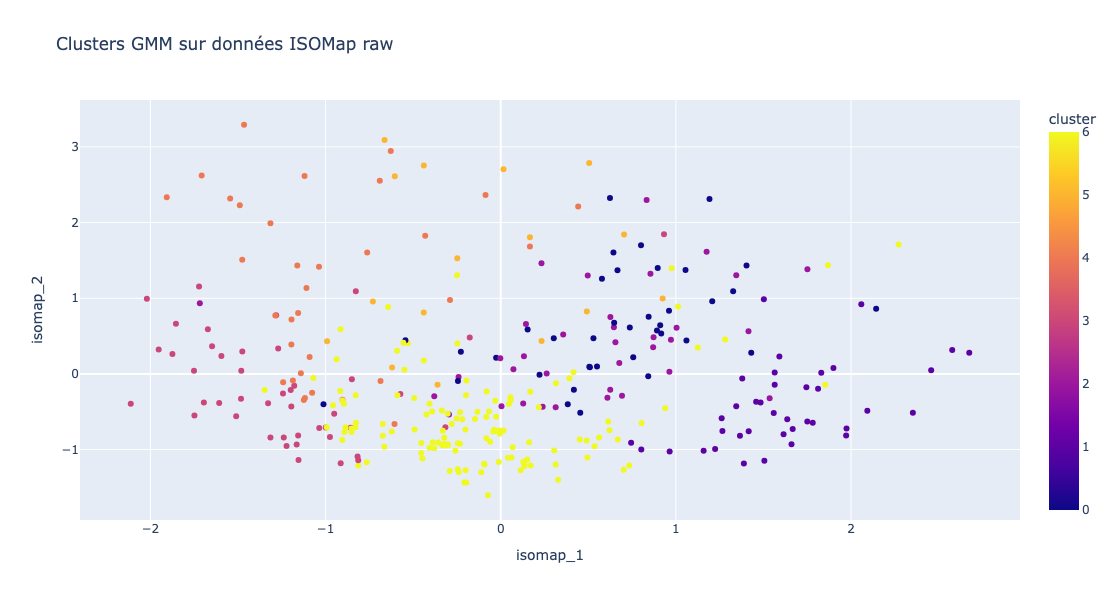

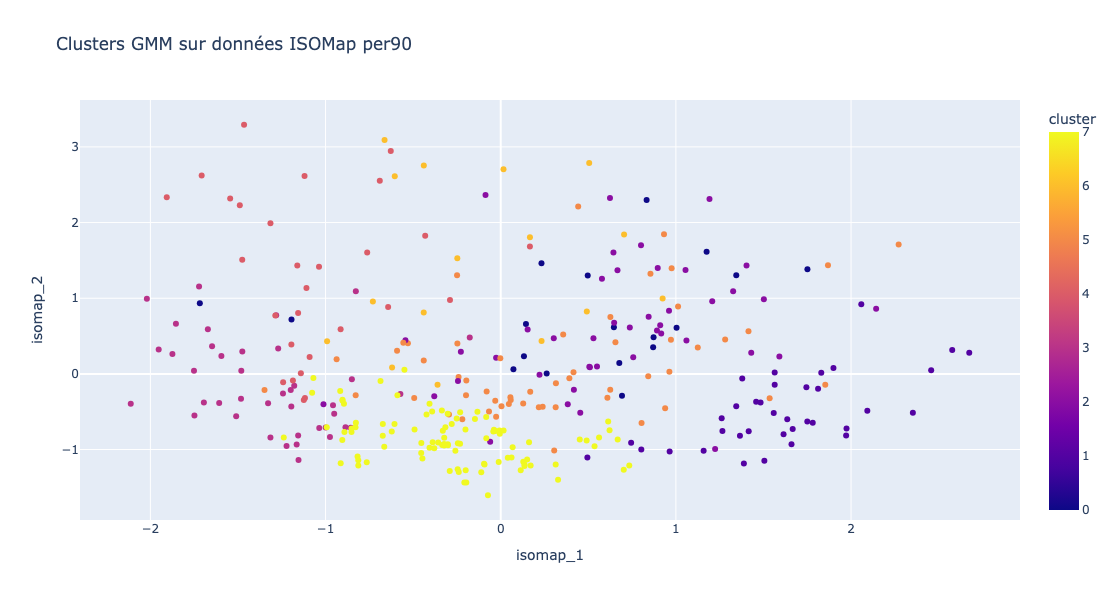

In [14]:
def print_results(X, column1, column2, data_name) :
    fig = px.scatter(
        X,
        x= column1, 
        y= column2, 
        color='cluster', 
        hover_data=['player_name', 'positions'],  # ce qui s'affiche au survol
        title=f"Clusters GMM sur données {data_name}",
        width=800, 
        height=600,
        color_discrete_sequence= None
    )
    fig.show()

print_results(X_aff_iso_raw, "isomap_1", "isomap_2", "ISOMap raw")
print_results(X_aff_iso_per90, "isomap_1", "isomap_2", "ISOMap per90")